## Problem to solve

Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests from Quality Assessment (QA). From these two tests,
you would like to determine whether the microchips should be accepted or
rejected. To help you make the decision, you have a dataset of test results
on past microchips, from which you can build a logistic regression model.

## Data

Data is provided in a text file with 3 columns in a csv format:
- Microchip Test 1
- Microchip Test 2
- Accepted (1) or Rejected (0)

Let's take a look at the data...

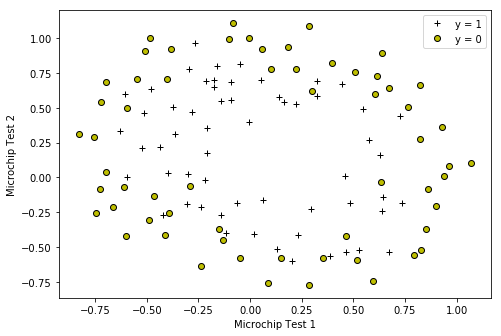

In [4]:
%matplotlib inline

# numpy for numerical computation
import numpy as np
# matplotlib for plotting
import matplotlib.pyplot as plt
# Scipy for optimization engine
from scipy.optimize import minimize

# plot data for training set
def plotData(E1, E2, y):
    fig_raw = plt.figure()
    ax = fig_raw.add_axes([0, 0, 1, 1 ])
    ax.plot( E1[y == True ], E2[y == True ], 'k+')
    ax.plot( E1[y == False ], E2[y == False ], 'ko', markerfacecolor='y')
    return ax

# file needs to be located in the same directory as your Jupiter notebook
# OR add the full path with a single forward slash '/'
# OR full path with double back slash '\\'
# Single and double quotation marks can be used interchangeably

# Read text file
# Floating point 64 bit is necessary to conserve full precision (14 decimals)
data = np.loadtxt('ex2data2.txt', dtype = np.float64 , delimiter=',')

# slice data and plot function
X1 = data[:,0]      # Exam 1 grade
X2 = data[:,1]      # Exam 2 grade
y = data[:,2]      # Chip validation

# plot data points using function defined above
axes_raw = plotData(X1, X2, y)
axes_raw.set_xlabel('Microchip Test 1')
axes_raw.set_ylabel('Microchip Test 2')
axes_raw.legend(['y = 1', 'y = 0'])

# Hypothesis

The logistic regression hypothesis is defined as: 
$$ h_\theta(x) = g(\theta^Tx)$$

where g is the sigmoid function:
$$ g(z) = \frac{1}{1 + e^{-z}}   \quad and \quad z = \theta^Tx$$

A straight line is not adequate to capture accepted and rejected microchip (see plot).<br>
One way to fit the data better is to create more features from each data
point. We will map the features into all polynomial terms of x1 and x2 up to the sixth power
<img src="FeatureMapping.png">
As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.
As a result it is also more susceptible to overfitting. Regularization can help combat the overfitting problem.

# Cost function and gradient

Now that we have our hypothesis, we need to find the optimal vector $\theta$ which yields the best results given our training set.
This is done by minimizing the cost function:<br>
The regularization term is boxed. $\lambda$ is the regularization parameter.
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)}log(h_\theta(x^{(i)})) - (1 - y^{(i)})log(1 - h_\theta(x^{(i)})) ] + \boxed{\frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2}$$

PS: cost function is similar to chi-square for fitting

To perform a gradient descent on our cost function we need to calculate the gradient:<br>
Note that you should not regularize parameter $\theta_0$
$$ \frac{\partial J(\theta)}{\partial \theta_j}  = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)})) - y^{(i)})x^{(i)}_j \qquad for\; j=0$$
$$ \frac{\partial J(\theta)}{\partial \theta_j}  = \left(\frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)})) - y^{(i)})x^{(i)}_j ) \right)+ \frac{\lambda}{m}\theta_j \qquad for\; j \geq 1$$

The optimal $\theta$ corresponds to the lowest value of $J(\theta)$. For a given vector $\theta$, global minima of $J(\theta)$ is determined by taking its derivative (gradient). Gradient descent is an iterative process to minimize $J(\theta)$ Because the sigmoid is convex, it will always converge to the global minima!


In [5]:
# sigmoid function for logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    
# add polynomial features built on top of existing pair of features
def mapFeatures(X1, X2, degree):
    # add vector bias
    out = np.ones(X1.shape)
    # add polynomes
    for i in range(1,degree+1, 1):
        for j in range(i+1):
            out = np.vstack( ( out, (np.power(X1,i-j)*np.power(X2,j)) ) )
    return out.T

# cost function for logistic regression
# return cost and gradient
def costFunction( theta, X, y, lambdaReg):
    # size is the number of element in the array, shape shows dimensions
    m = y.size
    # compute gradient
    grad = (1/m) * (sigmoid(np.dot(theta.T,X.T)) - y.T).dot(X)
    grad = grad + (lambdaReg/m)*np.concatenate( (np.zeros((1,)), theta[1:]) )
    
    J = (1/m) * ( np.dot(-y.T,  np.log(sigmoid(np.dot(theta.T,X.T)).T)) -
         np.dot((1-y.T), np.log(1 - sigmoid(np.dot(theta.T,X.T)).T)) )
    # add regularization term
    J = J + (lambdaReg/(2*m)) * np.dot(theta[1:], theta[1:])
    return (J, grad)

# Add polynomial features
DegreePolynomes = 8
Lambda = 1
X = mapFeatures(X1, X2, DegreePolynomes)
# X = np.vstack((X0, X)).T
             
# initialize fitting parameters
init_theta = np.zeros((X.shape[1], ))
#init_theta = np.array([-24, 0.2, 0.2])

# test cost function
#U = costFunction(init_theta, X, y)

# Minimize cost function using Broyden-Fletcher-Goldfarb-Shanno (BFGS)
# It is the equivalent of fminunc in Matlab optimization toolbox
# this is an unconstrained minimization
res = minimize(costFunction, init_theta, args=(X,y,Lambda), method='BFGS',
                 jac=True, options={'disp': True, 'maxiter': 400})
# get theta (returned as 'x' key) and cost (returned as 'fun' key)
theta = res['x']
cost = res['fun']

print(theta)

Optimization terminated successfully.
         Current function value: 0.523112
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
[ 1.25723042  0.64250057  1.1808067  -1.94809167 -0.91448758 -1.37996343
  0.19715337 -0.37102552 -0.37104368 -0.07202373 -1.36463866 -0.04826299
 -0.62139701 -0.28013228 -1.06671169 -0.1585542  -0.20375261 -0.04513221
 -0.27553822 -0.30691681 -0.30602146 -0.95051085  0.03117873 -0.29163832
  0.01547954 -0.32428062 -0.15276902 -0.76227187 -0.2788304  -0.09418474
 -0.04151836 -0.11393372 -0.03063718 -0.16934725 -0.20811472 -0.33502441
 -0.6845496   0.03788952 -0.15369203  0.01426298 -0.12785946  0.01485247
 -0.18712969 -0.10190032 -0.56072647]


## NOTE: Vary $\lambda$ and see for yourself how your decision boundary changes (rerun code above AND below)

# Decision boundary and prediction

We found our optimal $\theta$ parameters! <br>
Decision boundary is defined as $z=0$ equivalent to $x_0\theta_0+x_1\theta_1+x_2\theta_2+x_1^2\theta_3+x_1x_2\theta_4+...+x_2^6\theta_{28} = 0$<br>
In order to plot the non-linear decision boundary, classifier's predictions are computed on an evenly spaced grid and then and drew a contour plot of where the predictions change from y = 0 to y = 1. (see plotDecisionBoundary function)

The sigmoid function outputs a number between 0 and 1. In order to get a binary result the following rule applies:<br>
when $z \geq 0 \Rightarrow h_\theta(x) \geq 0.5 \Rightarrow$ classify result as admitted (1 logic)<br>
when $z < 0 \Rightarrow h_\theta(x) < 0.5 \Rightarrow$ classify result as not admitted (0 logic)

Train accuracy: 83.1%


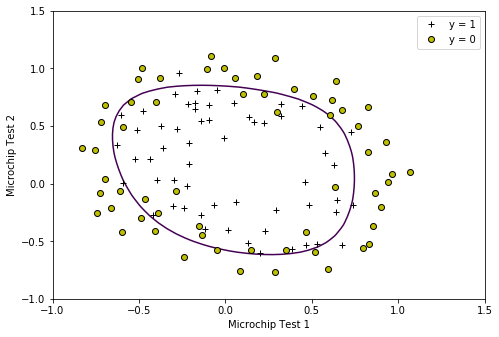

In [8]:
# plot decision boundary
def plotDecisionBoundary(theta, X, y, degree):
    # plot data first
    axd = plotData(X[:, 1], X[:, 2], y)
    if X.shape[1] <= 3 :
        # it's a line in this case so two points are enough for boundary
        plot_x = np.array([np.nanmin(X[:, 1])-2, np.nanmax(X[:, 1])+2])
        plot_y = -(theta[0] + plot_x*theta[1]) / theta[2]
        axd.plot(plot_x, plot_y)
    else:
        # Here is the grid range using for loops
#        u = np.linspace(-1, 1.5, 50)
#        v = np.linspace(-1, 1.5, 50)
#        z = np.zeros( (u.shape[0], v.shape[0]) )
#        # Evaluate z = theta*x over the grid
#        for i in range(0, (u.shape[0]), 1):
#            for j in range(0, v.shape[0], 1):
#                z[i,j] = mapFeatures(u[i], v[j], degree).dot(theta)
#        z = z.T # important to transpose z before calling contour
#        axd.contour(u, v, z, levels=[0],LineWidth=2)

        # Vectorization helps getting rid of for loops, same results as above
        u = np.linspace(-1, 1.5, 50)      
        Xu, Yv = np.meshgrid(u,u)
        z = mapFeatures(Xu.flatten(), Yv.flatten(), degree).dot(theta)
        z = np.reshape(z, (u.shape[0],u.shape[0]) )
        # Notice you need to specify level 0 to plot only z=0 line
        axd.contour(u, u, z, levels=[0],LineWidth=2)
        
    return axd
# return binary information based on probability
def predict(theta, X):
    p = np.zeros(X.shape[0], )
    p[ sigmoid(theta.T.dot(X.T)) >= 0.5 ] = 1   
    return p

# plot decision boundary (straight line in this case)
axe_bound = plotDecisionBoundary(theta, X, y, DegreePolynomes)
axe_bound.set_xlabel('Microchip Test 1')
axe_bound.set_ylabel('Microchip Test 2')
axe_bound.legend(['y = 1', 'y = 0', 'Decision boundary'])

# compute accuray on training set
p = predict(theta, X)
m = np.mean(p == y)*100
# OR m = p[p == y].shape
#print('Train accuracy: {}'.format(m))
print('Train accuracy: {0:.1f}%'.format(m))